Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import rdflib
from rdflib import Graph, Literal, Namespace, RDF, URIRef, OWL
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
from rdflib.namespace import DC, FOAF

from owlready2 import *
from owlready2 import get_ontology

from sklearn.model_selection import train_test_split

import networkx as nx
import networkx.algorithms.community as nx_comm

random.seed(10)

Loading the original data

In [2]:
data = pd.read_excel('/Users/ninaliem/Downloads/opioids_data_original.xlsx')
side_effects = pd.read_excel("/Users/ninaliem/Downloads/KRW_assign1-main/sider_output3.xlsx")
frequencies = pd.read_csv('meddra_freq.tsv', sep='\t', header=None)

Distribution of different outcome labels:

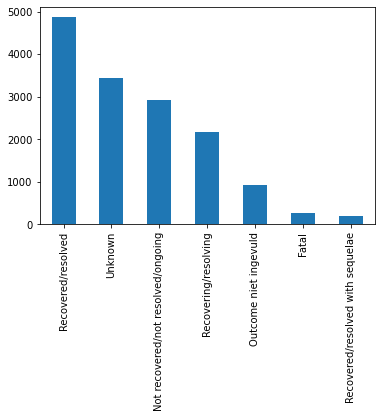

In [3]:
data.Outcome.value_counts().plot(kind='bar');

In [4]:
data['Outcome'].value_counts(normalize=True) * 100

Recovered/resolved                    32.909681
Unknown                               23.201731
Not recovered/not resolved/ongoing    19.808004
Recovering/resolving                  14.663332
Outcome niet ingevuld                  6.280422
Fatal                                  1.852353
Recovered/resolved with sequelae       1.284478
Name: Outcome, dtype: float64

Changing the 'Outcome' column values

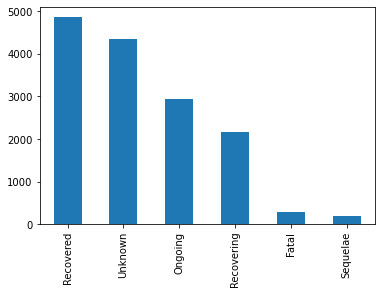

In [5]:
data['Outcome'] = data['Outcome'].replace(['Outcome niet ingevuld', 'Recovered/resolved', 'Not recovered/not resolved/ongoing', 'Recovered/resolved with sequelae', 'Recovering/resolving'], ['Unknown', 'Recovered', 'Ongoing', 'Sequelae', 'Recovering'])
#data = data[data['Outcome'] != 'Unknown']
data.Outcome.value_counts().plot(kind='bar');

In [6]:
data['Outcome'].value_counts(normalize=True) * 100

Recovered     32.909681
Unknown       29.482153
Ongoing       19.808004
Recovering    14.663332
Fatal          1.852353
Sequelae       1.284478
Name: Outcome, dtype: float64

**MISSING VALUES**

In [7]:
data.isna().sum()

WorldwideUniqueCaseIdentification        0
Status                                   0
Category                             14792
BodyWeight                            7165
Height                                7477
date_received                            0
sex                                      0
age_year                              2881
Outcome                                  0
OutcomeCodeSystemVersion             10003
OutcomeText                          12925
reaction_impact                      12153
ATCText                                  0
ATCode                                   0
GenericDrugName                          0
ID                                       0
CultureID                                0
LLTCode                                  0
LLTName                                  0
PTCode                                   0
PTName                                   0
HLTCode                                  0
HLTName                                  0
HLTGCode   

**DROP COLUMNS**

In [8]:
data = data.drop(columns=['Primary Source Description', 'Status', 'Category', 'OutcomeCodeSystemVersion', 'OutcomeText', 'CultureID', 'date_received', 'summary', 'narrative', 'IsCurrent', 'IsDefaultSOC'])

**REMOVE OUTLIERS**

- Removal of instances with bodyweight == 0 
- Removal of instances with height == 0

In [9]:
data = data[data.BodyWeight != 0] 
data = data[data.Height != 0] 

**CLEANING**

tramadol met paracetamol; N02AJ13 --> N02AX02
oxy met nalo; N02AA55 --> N02AA05
morf combi; N02AA51 --> N02AA01

In [10]:
data['ATCText'].replace(['TRAMADOL MET PARACETAMOL', 'OXYCODON MET NALOXON', 'MORFINE, COMBINATIEPREPARATEN'], ['TRAMADOL', 'OXYCODON', 'MORFINE'], inplace=True)

data['ATCode'].replace(['N02AJ13', 'N02AA51'], ['N02AX02', 'N02AA01'], inplace=True)

data['ATCText'] = data['ATCText'].str.lower()

**MERGING**

In [11]:
data = data.merge(side_effects[['ATCode', 'ATCText', 'PTCode', 'Side effect', 'Frequency']], how='left', on=['ATCode', 'ATCText', 'PTCode'])

The 'reaction_impact' column presumably measures the impact the medicine has had on the patient. As shown before, there is no reaction_impact for fatalities. 
We can impute the missing values by taking the average of a patient with similar features. 

To make this easier, we'll first create a column to bin the ages. We'll also create a BMI column and a weight group column.

In [12]:
data['age_group'] = pd.cut(x=data['age_year'], bins=[18, 24, 44, 64, 90])

data['BMI'] = data['BodyWeight'] / (data['Height']/100)**2

data['weight_group'] = pd.cut(x=data['BMI'], bins=[0, 18.5, 25, 30, 50], labels=['underweight', 'normal', 'overweight', 'obese'])

In [13]:
data['Frequency'] = data['Frequency'] * 100

In [14]:
data.reset_index(drop=True)

,WorldwideUniqueCaseIdentification,BodyWeight,Height,sex,age_year,Outcome,reaction_impact,ATCText,ATCode,GenericDrugName,...,HLTGCode,HLTGName,SOCCode,SOCName,SOCAbbreviation,Side effect,Frequency,age_group,BMI,weight_group
0,CF-NL-09-249,NaN,NaN,female,44.0,Unknown,NaN,tramadol,N02AX02,TRAMADOL CAPSULE 50MG,...,10037176,Psychiatric disorders NEC,10037175,Psychiatric disorders,Psych,NaN,NaN,"(24.0, 44.0]",NaN,NaN
1,CF-NL-09-249,NaN,NaN,female,44.0,Unknown,NaN,tramadol,N02AX02,TRAMADOL CAPSULE 50MG,...,10062915,Therapeutic and nontherapeutic effects (excl t...,10018065,General disorders and administration site cond...,Genrl,NaN,NaN,"(24.0, 44.0]",NaN,NaN
2,ES-KYOWAKIRIN-2019BKK009955,NaN,NaN,male,67.0,Unknown,NaN,fentanyl,N02AB03,FENTANYL NEUSSPRAY 100UG/DO,...,10033949,Parathyroid gland disorders,10014698,Endocrine disorders,Endo,Hypercalcaemia,NaN,"(64.0, 90.0]",NaN,NaN
3,ES-KYOWAKIRIN-2019BKK009955,NaN,NaN,male,67.0,Unknown,NaN,fentanyl,N02AB03,FENTANYL NEUSSPRAY 100UG/DO,...,10012221,Deliria (incl confusion),10037175,Psychiatric disorders,Psych,Disorientation,NaN,"(64.0, 90.0]",NaN,NaN
4,ES-KYOWAKIRIN-2019BKK009955,NaN,NaN,male,67.0,Unknown,NaN,fentanyl,N02AB03,FENTANYL NEUSSPRAY 100UG/DO,...,10013296,"Bone, calcium, magnesium and phosphorus metabo...",10027433,Metabolism and nutrition disorders,Metab,Hypercalcaemia,NaN,"(64.0, 90.0]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14645,NL-TEVA-824072ROM,NaN,NaN,male,46.0,Recovered,NaN,oxycodon,N02AA05,OXYCODON TABLET MGA 5MG,...,10040991,Sleep disorders and disturbances,10037175,Psychiatric disorders,Psych,NaN,NaN,"(44.0, 64.0]",NaN,NaN
14646,SE-TAKEDA-2016MPI004306,NaN,NaN,unknown,NaN,Ongoing,NaN,oxycodon,N02AA55,"OXYCODON/NALOXON TABLET MGA 5/2,5MG",...,10018012,Gastrointestinal signs and symptoms,10017947,Gastrointestinal disorders,Gastr,NaN,NaN,NaN,NaN,NaN
14647,US-SZ09-PHHO2015US018324,NaN,NaN,female,74.0,Recovering,NaN,tramadol,N02AX02,TRAMADOL CAPSULE MGA 50MG,...,10082206,"Cardiac disorders, signs and symptoms NEC",10007541,Cardiac disorders,Card,Dyspnoea,0.550000,"(64.0, 90.0]",NaN,NaN
14648,US-SZ09-PHHO2015US018324,NaN,NaN,female,74.0,Recovering,NaN,tramadol,N02AX02,TRAMADOL CAPSULE MGA 50MG,...,10038716,Respiratory disorders NEC,10038738,"Respiratory, thoracic and mediastinal disorders",Resp,Dyspnoea,0.550000,"(64.0, 90.0]",NaN,NaN


In [15]:
data.columns

Index(['WorldwideUniqueCaseIdentification', 'BodyWeight', 'Height', 'sex',
       'age_year', 'Outcome', 'reaction_impact', 'ATCText', 'ATCode',
       'GenericDrugName', 'ID', 'LLTCode', 'LLTName', 'PTCode', 'PTName',
       'HLTCode', 'HLTName', 'HLTGCode', 'HLTGName', 'SOCCode', 'SOCName',
       'SOCAbbreviation', 'Side effect', 'Frequency', 'age_group', 'BMI',
       'weight_group'],
      dtype='object')

In [16]:
gdn = list(data['GenericDrugName'].str.split(' ', expand=True).stack().unique())
type = ['CAPSULE', 'NEUSSPRAY', 'TABLET', 'PLEISTER', 'INJVLST', 'ZETPIL', 'DRANK', 'SPRAY', 'ZUIGTABLET', 'BRUISTABLET', 'INJ/INFOPL', 'INFVLST', 'DRUPPELS', 'SMELTTABLET', 'INJECTIE/INFUUS', 'DISPERTABLET', 'TAB', 'INJECTIEPOEDER']
dosage = []

def has_numbers(inputString):
    return bool(re.search(r'\d', inputString))

for i in gdn:
    if has_numbers(i):
        dosage.append(i)

data['Type'] = data['GenericDrugName'].apply(lambda x : ''.join([k for k in str(x).split() if k in type]))
data['Dosage'] = data['GenericDrugName'].apply(lambda x : ''.join([k for k in str(x).split() if k in dosage]))

In [17]:
data

,WorldwideUniqueCaseIdentification,BodyWeight,Height,sex,age_year,Outcome,reaction_impact,ATCText,ATCode,GenericDrugName,...,SOCCode,SOCName,SOCAbbreviation,Side effect,Frequency,age_group,BMI,weight_group,Type,Dosage
0,CF-NL-09-249,NaN,NaN,female,44.0,Unknown,NaN,tramadol,N02AX02,TRAMADOL CAPSULE 50MG,...,10037175,Psychiatric disorders,Psych,NaN,NaN,"(24.0, 44.0]",NaN,NaN,CAPSULE,50MG
1,CF-NL-09-249,NaN,NaN,female,44.0,Unknown,NaN,tramadol,N02AX02,TRAMADOL CAPSULE 50MG,...,10018065,General disorders and administration site cond...,Genrl,NaN,NaN,"(24.0, 44.0]",NaN,NaN,CAPSULE,50MG
2,ES-KYOWAKIRIN-2019BKK009955,NaN,NaN,male,67.0,Unknown,NaN,fentanyl,N02AB03,FENTANYL NEUSSPRAY 100UG/DO,...,10014698,Endocrine disorders,Endo,Hypercalcaemia,NaN,"(64.0, 90.0]",NaN,NaN,NEUSSPRAY,100UG/DO
3,ES-KYOWAKIRIN-2019BKK009955,NaN,NaN,male,67.0,Unknown,NaN,fentanyl,N02AB03,FENTANYL NEUSSPRAY 100UG/DO,...,10037175,Psychiatric disorders,Psych,Disorientation,NaN,"(64.0, 90.0]",NaN,NaN,NEUSSPRAY,100UG/DO
4,ES-KYOWAKIRIN-2019BKK009955,NaN,NaN,male,67.0,Unknown,NaN,fentanyl,N02AB03,FENTANYL NEUSSPRAY 100UG/DO,...,10027433,Metabolism and nutrition disorders,Metab,Hypercalcaemia,NaN,"(64.0, 90.0]",NaN,NaN,NEUSSPRAY,100UG/DO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14645,NL-TEVA-824072ROM,NaN,NaN,male,46.0,Recovered,NaN,oxycodon,N02AA05,OXYCODON TABLET MGA 5MG,...,10037175,Psychiatric disorders,Psych,NaN,NaN,"(44.0, 64.0]",NaN,NaN,TABLET,5MG
14646,SE-TAKEDA-2016MPI004306,NaN,NaN,unknown,NaN,Ongoing,NaN,oxycodon,N02AA55,"OXYCODON/NALOXON TABLET MGA 5/2,5MG",...,10017947,Gastrointestinal disorders,Gastr,NaN,NaN,NaN,NaN,NaN,TABLET,"5/2,5MG"
14647,US-SZ09-PHHO2015US018324,NaN,NaN,female,74.0,Recovering,NaN,tramadol,N02AX02,TRAMADOL CAPSULE MGA 50MG,...,10007541,Cardiac disorders,Card,Dyspnoea,0.550000,"(64.0, 90.0]",NaN,NaN,CAPSULE,50MG
14648,US-SZ09-PHHO2015US018324,NaN,NaN,female,74.0,Recovering,NaN,tramadol,N02AX02,TRAMADOL CAPSULE MGA 50MG,...,10038738,"Respiratory, thoracic and mediastinal disorders",Resp,Dyspnoea,0.550000,"(64.0, 90.0]",NaN,NaN,CAPSULE,50MG


In [18]:
data_ = data
#data_[data_['Frequency'] == 0.0] = 0.0001
data_['Frequency'] = data_['Frequency'].replace(0.0, 0.0001)
data_['Frequency'] = data_['Frequency'].fillna(0.0)

data_['is_sideeffect'] = data_['Side effect'].notna()
#data_['Side effect'] = data_['Side effect'].fillna('Unknown')

In [19]:
data_

,WorldwideUniqueCaseIdentification,BodyWeight,Height,sex,age_year,Outcome,reaction_impact,ATCText,ATCode,GenericDrugName,...,SOCName,SOCAbbreviation,Side effect,Frequency,age_group,BMI,weight_group,Type,Dosage,is_sideeffect
0,CF-NL-09-249,NaN,NaN,female,44.0,Unknown,NaN,tramadol,N02AX02,TRAMADOL CAPSULE 50MG,...,Psychiatric disorders,Psych,NaN,0.000000,"(24.0, 44.0]",NaN,NaN,CAPSULE,50MG,False
1,CF-NL-09-249,NaN,NaN,female,44.0,Unknown,NaN,tramadol,N02AX02,TRAMADOL CAPSULE 50MG,...,General disorders and administration site cond...,Genrl,NaN,0.000000,"(24.0, 44.0]",NaN,NaN,CAPSULE,50MG,False
2,ES-KYOWAKIRIN-2019BKK009955,NaN,NaN,male,67.0,Unknown,NaN,fentanyl,N02AB03,FENTANYL NEUSSPRAY 100UG/DO,...,Endocrine disorders,Endo,Hypercalcaemia,0.000000,"(64.0, 90.0]",NaN,NaN,NEUSSPRAY,100UG/DO,True
3,ES-KYOWAKIRIN-2019BKK009955,NaN,NaN,male,67.0,Unknown,NaN,fentanyl,N02AB03,FENTANYL NEUSSPRAY 100UG/DO,...,Psychiatric disorders,Psych,Disorientation,0.000000,"(64.0, 90.0]",NaN,NaN,NEUSSPRAY,100UG/DO,True
4,ES-KYOWAKIRIN-2019BKK009955,NaN,NaN,male,67.0,Unknown,NaN,fentanyl,N02AB03,FENTANYL NEUSSPRAY 100UG/DO,...,Metabolism and nutrition disorders,Metab,Hypercalcaemia,0.000000,"(64.0, 90.0]",NaN,NaN,NEUSSPRAY,100UG/DO,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14645,NL-TEVA-824072ROM,NaN,NaN,male,46.0,Recovered,NaN,oxycodon,N02AA05,OXYCODON TABLET MGA 5MG,...,Psychiatric disorders,Psych,NaN,0.000000,"(44.0, 64.0]",NaN,NaN,TABLET,5MG,False
14646,SE-TAKEDA-2016MPI004306,NaN,NaN,unknown,NaN,Ongoing,NaN,oxycodon,N02AA55,"OXYCODON/NALOXON TABLET MGA 5/2,5MG",...,Gastrointestinal disorders,Gastr,NaN,0.000000,NaN,NaN,NaN,TABLET,"5/2,5MG",False
14647,US-SZ09-PHHO2015US018324,NaN,NaN,female,74.0,Recovering,NaN,tramadol,N02AX02,TRAMADOL CAPSULE MGA 50MG,...,Cardiac disorders,Card,Dyspnoea,0.550000,"(64.0, 90.0]",NaN,NaN,CAPSULE,50MG,True
14648,US-SZ09-PHHO2015US018324,NaN,NaN,female,74.0,Recovering,NaN,tramadol,N02AX02,TRAMADOL CAPSULE MGA 50MG,...,"Respiratory, thoracic and mediastinal disorders",Resp,Dyspnoea,0.550000,"(64.0, 90.0]",NaN,NaN,CAPSULE,50MG,True


In [ ]:
data_ = data_.reset_index(drop=True)

In [20]:
data_.to_excel("opioid_data_merged2.xlsx") 

In [ ]:
data_

In [ ]:
onto = get_ontology("http://example.org/medsur.owl")

class Patients(Thing):
    namespace = onto

class AgeGroup(Thing):
    namespace = onto
 
class hasAgeGroup(ObjectProperty):                  # TODO: do we need to define ranges for our properties?
    domain = [Patients]
    range = [AgeGroup]
    namespace = onto
  
class WeightGroup(Thing):
    namespace = onto
    
class hasWeightGroup(ObjectProperty):   # is this range correct if we connect patient directly to weightgroup is rdf tripple, else delete range
    domain = [Patients]
    range = [WeightGroup]
    namespace = onto
    
class Symptoms(Thing):
    namespace = onto
    
class hasSymptom(ObjectProperty):
    domain = [Patients]
    range = [Symptoms]
    namespace = onto

class Outcome(Thing):
    namespace = onto
    
class hasOutcome(ObjectProperty):
    domain = [Patients]
    range = [Outcome]
    namespace = onto
    
class Gender(Thing):
    namespace = onto

class hasGender(ObjectProperty):
    domain = [Patients]
    range = [Gender]
    namespace = onto

class Drug(Thing):
    namespace = onto
    
class IsGivenDrug(ObjectProperty):
    domain = [Patients]
    range = [Drug]
    namespace = onto
    
class IsOfDosis(ObjectProperty):
    domain = [Drug]
    namespace = onto
    
class IsOfType(ObjectProperty):
    domain = [Drug]
    namespace = onto

class SideEffects(Thing):
    namespace = onto
    
class hasSideEffect(ObjectProperty):
    domain = [Drug]
    range = [SideEffects]
    namespace = onto
    
class hasFrequency(ObjectProperty):                 
    domain = [SideEffects]
    namespace = onto 

In [ ]:
onto.save(file = "medsur.rdf", format = "rdfxml") 
g = rdflib.Graph()
g.parse("medsur.rdf", format="xml")

# Loop through each triple in the graph (subj, pred, obj)
for subj, pred, obj in g:
    
    # Check if there is at least one triple in the Graph
    if (subj, pred, obj) not in g:
       raise Exception("It better be!")

# Print the number of "triples" in the Graph
print(f"Graph g has {len(g)} statements.")

In [ ]:
# print all the triples in the graph 
for s, p, o in g:
    print(s, p, o)

In [ ]:
data_['WorldwideUniqueCaseIdentification'] = data_['WorldwideUniqueCaseIdentification'].astype(str)
data_['age_group'] = data_['age_group'].astype(str)
data_['PTCode'] = data_['PTCode'].astype(str)

In [ ]:
# add RDF triples to the ontology
EX = rdflib.Namespace("http://example.org/medsur.rdf#")

for index, row in data_.iterrows():

    patient = URIRef(f"http://www.medsur.org/patient_{row['WorldwideUniqueCaseIdentification']}")
    g.add((patient, RDF.type, EX.Patients))

    weight_group = URIRef(f"http://www.medsur.org/weight/{row['weight_group']}")
    g.add((weight_group, RDF.type, EX.WeightGroup))
    g.add((patient, EX.hasWeightGroup, weight_group))

    # age_group = URIRef(f"http://www.medsur.org/age/{row['age_group']}")
    # g.add((age_group, RDF.type, EX.AgeGroup))
    # g.add((patient, EX.hasAgeGroup, age_group))
    if float(row["age_year"]) >= 65:
        agegroup = URIRef("http://www.medsur.org/age/65_above")
    elif float(row["age_year"]) >= 45:
        agegroup = URIRef("http://www.medsur.org/age/45_64") 
    elif float(row["age_year"]) >= 25:
        agegroup = URIRef("http://www.medsur.org/age/25_44")
    elif float(row["age_year"]) >= 18:
        agegroup = URIRef("http://www.medsur.org/age/18_24")
    
    g.add((agegroup, RDF.type, EX.AgeGroup))
    g.add((patient, EX.hasAgeGroup, agegroup))

    gender = URIRef(f"http://www.medsur.org/gender/{row['sex']}")
    g.add((gender, RDF.type, EX.Gender))
    g.add((patient, EX.hasGender, gender))

    outcome = URIRef(f"http://www.medsur.org/outcome/{row['Outcome']}")
    g.add((outcome, RDF.type, EX.Outcome))
    g.add((patient, EX.hasOutcome, outcome))

    symptom = URIRef(f"http://www.medsur.org/symptom/{row['PTCode']}")
    g.add((symptom, RDF.type, EX.Symptoms))
    g.add((patient, EX.hasSymptom, symptom))

    drug = URIRef(f"http://www.medsur.org/drug/{row['ATCode']}")              
    g.add((drug, RDF.type, EX.Drug))   
    g.add((patient, EX.isGivenDrug, drug))

    if row['is_sideeffect'] == True:
        side_effect = URIRef(f"http://www.medsur.org/side_effect/{row['PTCode']}")
        g.add((side_effect, RDF.type, EX.SideEffects))
        g.add((drug, EX.hasSideEffect, side_effect))

    g.add((side_effect, EX.hasFrequency, Literal(row['Frequency'])))

In [ ]:
nx_graph = rdflib_to_networkx_digraph(g)
print("Number of Nodes: {n}".format(n=nx.number_of_nodes(nx_graph)))
print("Number of Edges: {n}".format(n=nx.number_of_edges(nx_graph)))
print("Density of Graph: {n}".format(n=nx.density(nx_graph)))
print("Clustering coefficient: {n}".format(n=nx.average_clustering(nx_graph)))
print("Degree centrality:", nx.degree_centrality(nx_graph))

In [ ]:
histdegree = pd.DataFrame(nx.degree_histogram(nx_graph))
degree = dict(nx.degree(nx_graph))

mean_degree = np.mean(list(degree.values()))
mean_degree_centrality = np.mean(list(nx.degree_centrality(nx_graph).values()))

fig, ax = plt.subplots(figsize=(12,6)) 
ax.bar(histdegree.index.values,histdegree[0])

plt.title("Mean Degree: {n1}\n Mean Degree Centrality: {n2}".format(n1=mean_degree,n2=mean_degree_centrality))
plt.show()

In [ ]:
def find_blanknodes(g):
    blank_nodes = []
    BNode = rdflib.term.BNode
    for s, p, o in g:
        if isinstance(s, BNode):
            blank_nodes.append(s)
        if isinstance(o, BNode):
            blank_nodes.append(o)
    return blank_nodes 

print("Number of Blank Nodes: {n}".format(n=len(find_blanknodes(g))))

In [ ]:

def clustering_louvain(nx_graph):
    
    mapping = pd.DataFrame(nx_graph.nodes())
    mapping['new_names'] = mapping[0].str.split("#",n=1,expand=False)
    mapping['label'] = 'NA'

    mapping_copy = mapping.copy()

    for ind, m in mapping_copy.iterrows():
        l = len(m['new_names'])
        names = m['new_names']
        mapping.loc[ind,'label'] = names[l-1]

    map_dict = dict(zip(mapping[0],mapping['label']))
    nx_graph_nl = nx.relabel_nodes(nx_graph, map_dict,copy=True)
    communities = nx_comm.louvain_communities(nx_graph_nl,resolution=1)
    print('Number of found communitites', len(communities),
    '\n Number of nodes in the graph',nx.number_of_nodes(nx_graph_nl))
    for i in range(len(communities)):
        print(f'{i}th community: \n',communities[i] )
        

    pos = nx.shell_layout(nx_graph_nl)
    nx.draw(nx_graph_nl, pos, edge_color='k',font_weight='light', 
            node_size= 100, width= 0.8)

    for com in communities:
        nx.draw_networkx_nodes(nx_graph_nl,
                            pos,
                            nodelist=com, 
                            #node_color=np.random.rand(3,),
                            node_color = range(len(com)),
                            label=True,
                            node_size=100)   
    return

clustering_louvain(nx_graph) 
